In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

In [2]:
import pickle
import boto3
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

## Importamos la información

In [3]:
session = boto3.session.Session()
s3client = session.client('s3')

In [4]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/features_train.pkl')

body = response['Body'].read()
features_train = pickle.loads(body)

In [5]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/labels_train.pkl')

body = response['Body'].read()
labels_train = pickle.loads(body)

In [6]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/features_test.pkl')

body = response['Body'].read()
features_test = pickle.loads(body)

In [7]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/labels_test.pkl')

body = response['Body'].read()
labels_test = pickle.loads(body)

In [8]:
response = s3client.get_object(Bucket='inai-summerofdata', Key='mlpreproc/pickles_sample_year_dependencia/df.pkl')

body = response['Body'].read()
df = pickle.loads(body)

In [9]:
features_train.shape

(5783, 300)

In [10]:
features_test.shape

(1446, 300)

## Cross-Validation para tuneo de hyperparámetros

In [11]:
rf_0 = RandomForestClassifier(random_state = 8)
pprint(rf_0.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


In [12]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=1000, num=5)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(20, 100, num=5)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


cambiar a precision

In [13]:
rfc = RandomForestClassifier(random_state=8)

busqueda = RandomizedSearchCV(estimator=rfc,
                                  param_distributions=random_grid,
                                  n_jobs=-1,
                                  n_iter=50,
                                  scoring='accuracy',
                                  cv=3,
                                  verbose=1,
                                  random_state=8)

busqueda.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [14]:
print(busqueda.best_params_)

{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


In [15]:
print(busqueda.best_score_)

0.7259208023517205


Acotamos nuestra busqueda considerando los valores encontrados.

**Grid Search Cross Validation**

In [16]:
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

rfc = RandomForestClassifier(random_state=8)

cv_sets = ShuffleSplit(n_splits=3, test_size=0.33, random_state=8)

grid_search = GridSearchCV(estimator=rfc,
                          param_grid=param_grid,
                          n_jobs=-1,
                          scoring='accuracy',
                          cv=cv_sets,
                          verbose=1)

grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  3.7min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_...
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=8,
                                              verbose=0, warm_start=False),
  

In [17]:
print(grid_search.best_params_)

{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}


In [18]:
print(grid_search.best_score_)

0.7312729177579885


**Modelo**

In [19]:
best_rfc = grid_search.best_estimator_

In [20]:
best_rfc

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

##  Fit y desempeño del modelo

Modelamos con la data de entrenamiento

In [21]:
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=30, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)

Predicciones

In [22]:
rfc_pred = best_rfc.predict(features_test)

**training accuracy**

In [23]:
print(accuracy_score(labels_train, best_rfc.predict(features_train)))

0.8751513055507522


**test accuracy**

In [24]:
print(accuracy_score(labels_test, rfc_pred))

0.7026279391424619


**classification report**

In [25]:
print(classification_report(labels_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.62      0.72      0.67       593
           1       0.78      0.69      0.73       853

    accuracy                           0.70      1446
   macro avg       0.70      0.71      0.70      1446
weighted avg       0.71      0.70      0.70      1446



**confusion matrix**

<function matplotlib.pyplot.show(*args, **kw)>

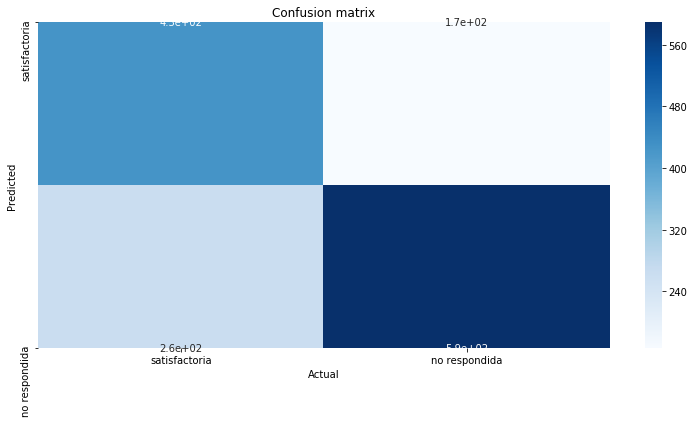

In [26]:
aux_df = df[['calidad_respuesta_real', 'codigo_calidad_respuesta_real']].drop_duplicates().sort_values('codigo_calidad_respuesta_real')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
           annot=True,
           xticklabels=aux_df['calidad_respuesta_real'].values,
           yticklabels=aux_df['calidad_respuesta_real'].values,
           cmap='Blues')

plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show

Creamos un dataframe

In [27]:
data = {
    'Modelo': 'Random Forest',
    'Training Set Accuracy': accuracy_score(labels_train, best_rfc.predict(features_train)),
    'Test Set Accuracy': accuracy_score(labels_test, rfc_pred)
}

df_models_rfc = pd.DataFrame(data, index=[0])

In [28]:
df_models_rfc

,Modelo,Training Set Accuracy,Test Set Accuracy
0,Random Forest,0.875151,0.702628


## Guardamos en S3

In [ ]:
bucket='inai-summerofdata'
key='modeling/random_forest/0_year_dependencia/best_rfc.pkl'
pickle_byte_obj = pickle.dumps(best_rfc)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)

In [ ]:
bucket='inai-summerofdata'
key='modeling/random_forest/0_year_dependencia/df_models_rfc.pkl'
pickle_byte_obj = pickle.dumps(df_models_rfc)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, key).put(Body=pickle_byte_obj)